#CAM Analysis
saskiad@alleninstitute.org

Imports and dependencies

In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import CAM_NWB as cn

#display options for Pandas
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 6)

##NWB file for CAM data contains a number of items:
    metadata (Cre line, visual area, etc)
    stimulus table
    link to movie
    motion correction (x and y translation of each frame)
    maximum projection of movie
    ROI masks
    ROI traces
    mouse running speed

Provide path to dataset and open NWB file.  We have provided a script that will load these different pieces of information.

In [4]:
#point path to dataset 
path = r'HARDDRIVE PATH/CAM/479681980/479681980.nwb'
#path = r'/Volumes/Brain2015/CAM/479681980/479681980.nwb'

The CAM_NWB module we imported has a number of functions for getting these items from the NWB file. 

In [2]:
dir(cn)

['__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'getFluorescenceTraces',
 'getMaxProjection',
 'getMetaData',
 'getMotionCorrection',
 'getROImask',
 'getRunningSpeed',
 'getStimulusTable',
 'h5py',
 'np',
 'pd']

First let's look at the metadata associated with this experiment.  For your projects, you will likely want to choose experiments for specific metadata conditions (eg. specific HVA or imaging depth).

In [25]:
#getMetaData returns a dictionary of meta information
meta = cn.getMetaData(path)
print meta

{'lims_id': '479681980', 'HVA': 'V1', 'specimen': '180818', 'system': '2p2', 'depth': '175', 'Cre': 'Emx1'}


#Display maximum projection of field of view
This dataset is from 2-photon calcium imaging, in which a movie was collected of calcium activity of cells in the mouse visual cortex.  Let's start by looking at our field of view and the cells that were active.  To do this, let's open the maximum projection and display it.

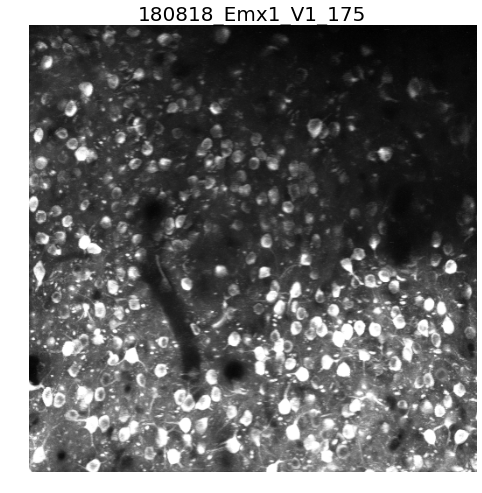

In [21]:
#getMaxProjection returns a 512x512 array of the maximum projection of the 2P movie
max_projection = cn.getMaxProjection(path)

#display image and add title
plt.figure(figsize=(8,8))
plt.imshow(max_projection,cmap='gray')
plt.axis('off')
plt.title(meta['specimen']+"_"+meta['Cre']+"_"+str(meta['HVA'])+"_"+str(meta['depth']), fontsize=20)

# Load ROI masks

The first step in analyzing 2P data is segmentation - isolating ROIs for each cell. Each ROI mask is saved as a separate object in the NWB file, and is used to extract the fluorescence trace for each ROI.

In [10]:
#getROImask returns an array containing a 512X512 image of the ROI mask for each cell. The entire array is #cellsX512X512.
roi_array = cn.getROImask(path)
roi_array.shape

(575, 512, 512)

Display all ROI masks over max projection

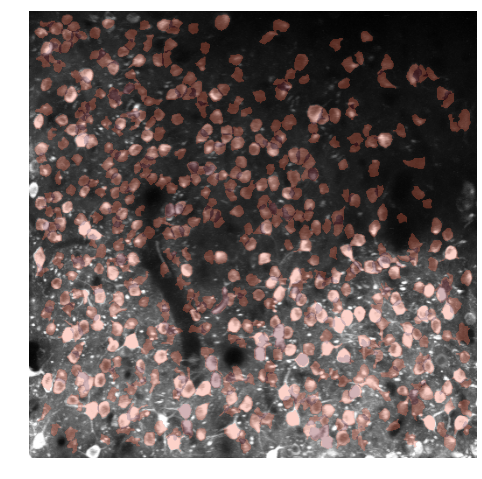

In [11]:
#sum all ROIs
output = roi_array.sum(axis=0)

#make background transparent
output[output==0]=np.NaN

#display
plt.figure(figsize=(8,8))
plt.imshow(max_projection,cmap='gray')
plt.axis('off')
plt.imshow(output, cmap='Reds', vmin=0.9, vmax=1.1, alpha=0.3)

For each ROI, the fluorescence values were extracted from the movie, resulting in an array of time series of the calcium activity for each ROI.

In [3]:
#getFluorescenceTraces returns an array of raw fluorescence traces for each ROI and the timestamps for each time point.
timestamps, celltraces = cn.getFluorescenceTraces(path)

number_cells = np.size(celltraces,0)
acquisition_rate = 1/(timestamps[1]-timestamps[0]) 
print "Number of cells: ", number_cells
print "Acquisition rate: ", acquisition_rate

Number of cells:  575
Acquisition rate:  30.0571085062


#Plot some Fluorescence traces
Let's look at some of the responses from some ROIS

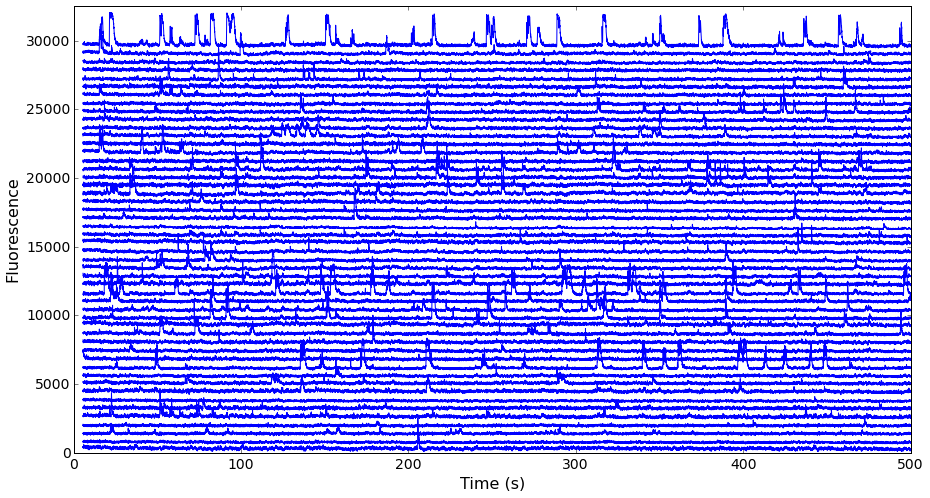

In [4]:
plt.figure(figsize=(15,8))
for i,v in enumerate(celltraces[200:250,:]):
    v = v -np.min(v)
    plt.plot(timestamps,v+(i*600),color='blue')
plt.xlim(0,500)
plt.ylim(0,32500)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Fluorescence", fontsize=16)
plt.tick_params(labelsize=14)

#Stimulus Information
Load stimulus information from the NWB file

In [5]:
#getStimulusTable returns DataFrame of stimulus conditions
stimulus_table = cn.getStimulusTable(path)

number_sweeps = len(stimulus_table)
print "Number of stimulus sweeps: ", number_sweeps
stimulus_table

Number of stimulus sweeps:  630


,start,end,temporal_frequency,orientation,blank_sweep
0,289,348,8,0,0
1,379,439,4,135,0
2,469,529,1,45,0
3,560,619,4,225,0
4,650,709,15,135,0
...,...,...,...,...,...
625,56696,56756,2,45,0
626,56787,56846,NaN,NaN,1
627,56877,56937,2,0,0
628,56967,57027,15,0,0


Let's examine the stimulus

In [24]:
#find unique orientation values
orivals = stimulus_table.orientation.dropna().unique()
orivals.sort()

#find unique temporal frequency values
tfvals = stimulus_table.temporal_frequency.dropna().unique()
tfvals.sort()

#calculate length of stimulus sweeps and inter-sweep intervals
sweeplength = stimulus_table['end'][1] - stimulus_table['start'][1]
intersweep = stimulus_table['start'][2] - stimulus_table['end'][1]

#print results
print "%s Orientations: "%len(orivals), orivals
print "%s Temporal frequencies: "%len(tfvals), tfvals
print "Sweep duration: ", sweeplength
print "Intersweep interval: ", intersweep
print "Number of trials: ", len(stimulus_table[(stimulus_table['temporal_frequency']==tfvals[0])&(stimulus_table['orientation']==orivals[0])])

8 Orientations:  [   0.   45.   90.  135.  180.  225.  270.  315.]
5 Temporal frequencies:  [  1.   2.   4.   8.  15.]
Sweep duration:  60.0
Intersweep interval:  30.0
Number of trials:  15


The "blank_sweep" column indicates the occurrence of blanksweeps when no grating is presented, which is a valuable control condition.

In [20]:
blank = stimulus_table[stimulus_table['blank_sweep']==1]
print "Number of blank trials: ", len(blank)

Number of blank trials:  30


Now we can look at some visual responses. First, let's pick a cell to look at.

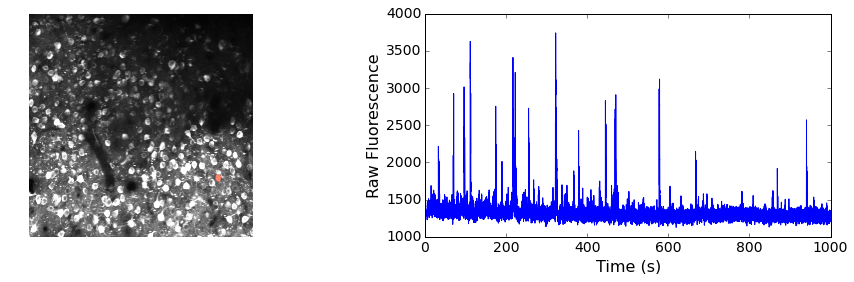

In [12]:
roi_id = 234

#display ROI mask and raw fluorescence trace
mask = roi_array[roi_id,:,:]
mask[mask>0]=1
mask[mask==0]=np.NaN
plt.figure(figsize=(16,4))
ax1 = plt.subplot(121)
ax1.imshow(max_projection,cmap='gray')
ax1.axis('off')
ax1.imshow(mask, cmap='Reds', vmin=0.9, vmax=1.1, alpha=0.8)
ax2 = plt.subplot(122)
ax2.plot(timestamps, celltraces[roi_id,:])
ax2.set_xlim(0,1000)
ax2.set_xlabel("Time (s)", fontsize=16)
ax2.set_ylabel("Raw Fluorescence", fontsize=16)
ax2.tick_params(labelsize=14)

To start, let's just look at the response to a specific stimulus, say TF=2 and Ori=270.

In [109]:
stimulus_subset = stimulus_table[(stimulus_table['temporal_frequency']==2)&(stimulus_table['orientation']==270)]
stimulus_subset

,start,end,temporal_frequency,orientation,blank_sweep
27,2725,2785,2,270,0
69,6516,6575,2,270,0
102,9496,9556,2,270,0
109,10128,10188,2,270,0
143,13196,13256,2,270,0
...,...,...,...,...,...
484,43973,44032,2,270,0
541,49116,49176,2,270,0
567,51463,51522,2,270,0
617,55975,56034,2,270,0


Let's plot the response of the cell to the first presentation of this grating condition. If we aren't looking at the dataframe subset directly, we have no idea what the actual index of the first presentation is.  We can acess it using the **iloc** indexing function.

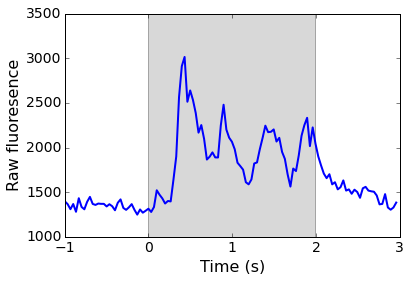

In [110]:
sweep_start = stimulus_subset['start'].iloc[0]
time_trace = timestamps[sweep_start-intersweep:sweep_start+sweeplength+intersweep]
time_trace -= timestamps[sweep_start]        #set start of grating sweep to time=0
plt.plot(time_trace, celltraces[roi_id, sweep_start-intersweep:sweep_start+sweeplength+intersweep], lw=2)
plt.axvspan(0,sweeplength/acquisition_rate ,ymin=0, ymax=1, facecolor='gray', alpha=0.3)
plt.ylabel("Raw fluorescence", fontsize=16)
plt.xlabel("Time (s)", fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(range(-1,4));

Let's do this analysis across all of the cells. We can use a DataFrame to contain the DF/F trace for each cell (in columns) in response to each grating (in rows).

In [35]:
#create an empty DataFrame with columns for each ROI and index (rows) for each stimulus sweep
sweep_response = pd.DataFrame(index=stimulus_table.index.values, columns=np.array(range(number_cells)).astype(str))

#populate DataFrame with DF/F trace of each ROI in response to each grating
for index, row in stimulus_table.iterrows():
    start = row['start'] - intersweep
    end = row['start'] + sweeplength + intersweep
    for nc in range(number_cells):
        temp = celltraces[nc,start:end]                                
        sweep_response[str(nc)][index] = 100*((temp/np.mean(temp[:intersweep]))-1)   #locally defined DF/F

In [45]:
#examine the resulting DataFrame
print "sweep_response shape: ", sweep_response.shape
print "sweep_response element shape: ", sweep_response['0'][0].shape
sweep_response

sweep_response shape:  (630, 575)
sweep_response element shape:  (120,)


,0,1,2,...,572,573,574
0,"[-0.977075, 7.84274, -2.95204, 0.810921, -2.42...","[-5.01843, -4.07611, -1.59695, -3.17814, 0.679...","[-8.19868, 5.04639, -1.42866, -1.84411, -5.074...",...,"[3.95466, 0.911248, 3.03425, -5.3237, -1.96543...","[-4.79179, -7.68896, -10.6003, -3.6215, 4.2045...","[-0.963748, -1.9146, 1.27709, 4.16356, -4.0891..."
1,"[-1.98175, 6.10523, -2.98533, -5.01371, -0.657...","[-38.4894, -40.151, -36.4293, -42.7691, -40.37...","[2.30764, -3.73747, -1.94435, -4.03634, -2.615...",...,"[6.98397, 3.95991, 7.36166, 6.84801, 3.84685, ...","[-11.371, -8.87076, -12.085, -13.1282, -6.0298...","[5.93228, 5.85675, -0.468051, 2.91446, 0.50880..."
2,"[-0.472128, 3.80578, -2.59887, -8.842, -1.8483...","[-42.7579, -47.7247, -43.3192, -43.0451, -40.7...","[-3.51247, -1.63726, -4.82928, -4.09672, 15.19...",...,"[7.60974, 7.82148, 7.5797, 4.69625, 0.391269, ...","[3.85975, 5.00709, 5.86233, 6.10874, 1.84639, ...","[7.69966, 2.09998, 8.51527, -0.188202, 5.64821..."
3,"[-3.18237, 2.77922, -2.35302, -4.25606, -1.811...","[-28.9105, -28.8193, -28.3106, -35.0584, -31.1...","[2.68929, -6.16763, -3.16907, 4.74643, 9.88926...",...,"[3.06224, -0.480407, -0.354487, -3.0102, -0.17...","[4.20871, -0.631833, 1.76928, 4.23871, -0.3342...","[5.31243, 6.16287, 1.14522, 4.4701, 2.63228, 3..."
4,"[-2.49477, 13.4951, 4.74759, 5.29352, 13.0959,...","[-36.0705, -31.5965, -31.2639, -36.3888, -34.4...","[-9.77097, 0.849748, 0.586581, 4.4269, 6.34052...",...,"[0.872493, 0.579965, 0.75767, 6.34353, 5.26632...","[-2.47895, -6.46719, -5.52203, 1.60925, 4.3145...","[7.8807, 4.47122, 7.82368, 1.08771, 5.54066, -..."
...,...,...,...,...,...,...,...
625,"[7.76443, -1.15374, -0.31575, 7.88082, 1.07071...","[-6.56197, -1.04147, -5.1535, -0.560731, -0.14...","[-4.70088, 3.86493, 6.9589, 12.9807, 7.05646, ...",...,"[0.623679, -2.34194, -3.64404, 5.21239, 2.3596...","[2.95882, 0.910556, 2.02751, -0.739974, 2.3810...","[-1.77025, 0.5198, 2.99898, 2.13895, 2.91471, ..."
626,"[0.156617, -1.32741, 5.81863, -5.91881, -2.316...","[-37.1304, -29.1444, -33.8103, -29.6617, -33.1...","[-10.1416, -6.25374, -9.983, -4.56666, 6.34873...",...,"[1.57292, -0.854164, -2.15306, -1.56187, 1.650...","[3.17672, 3.82422, 2.51234, 1.47645, -6.60567,...","[-2.61927, 3.74438, -2.59733, -2.75496, -2.438..."
627,"[6.25798, -1.67361, -2.63562, -4.44031, -4.731...","[-5.81063, -1.256, -2.10678, -0.125051, 4.0102...","[-4.4239, -3.59272, -9.74234, -6.99652, -3.881...",...,"[-0.526106, -0.463933, -0.0294983, -3.90344, 0...","[2.42879, -3.17672, 1.02994, -2.70131, 0.86979...","[-1.96859, -5.85577, -5.37646, 0.881457, -3.96..."
628,"[-6.81442, -3.09771, 4.66352, -2.17738, -3.217...","[-29.8785, -25.7177, -30.2417, -23.0185, -28.7...","[0.63926, -9.73397, -6.81658, -0.377548, -1.77...",...,"[-4.63499, -1.64652, -1.07548, 2.08259, 0.7127...","[0.848985, -6.30141, 1.79255, -6.84851, -1.037...","[-6.2614, 2.23686, -2.0593, -5.48022, -0.27526..."


This data is now in DF/F where we've normalized the fluorescence values for each sweep by the fluorescence during the preceding intersweep interval.  Let's look at the sweep we saw above.

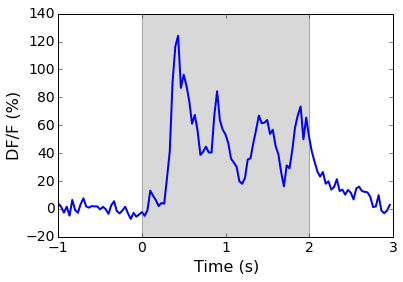

In [80]:
time_sweep = np.arange(-1*intersweep/acquisition_rate, (sweeplength+intersweep)/acquisition_rate, 1/acquisition_rate)
plt.plot(time_sweep, sweep_response[str(roi_id)][27], lw=2)
plt.axvspan(0,sweeplength/acquisition_rate ,ymin=0, ymax=1, facecolor='gray', alpha=0.3)
plt.ylabel("DF/F (%)", fontsize=16)
plt.xlabel("Time (s)", fontsize=16)
plt.tick_params(labelsize=14)
plt.xticks(range(-1,4));

Plot average trace for all grating conditions for our chosen ROI

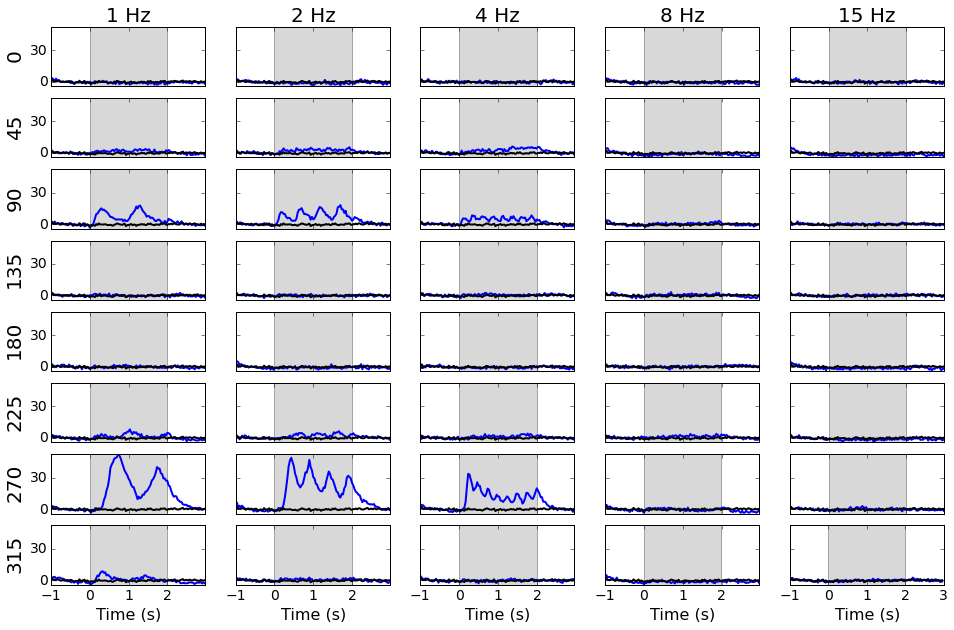

In [95]:
roi_id = 234

#create a subset for just the blanksweeps
blank = sweep_response[stimulus_table['blank_sweep']==1]

#create figure with subplots for all orientation and temporal frequency conditions
fig,ax = plt.subplots(len(orivals), len(tfvals), sharex=True, sharey=True)
fig.set_size_inches(16,10)
minval = 0
maxval = 0
#iterate through all the grating conditions
for i,ori in enumerate(orivals):
    for j,tf in enumerate(tfvals):
        #get subset of sweeps for that grating condition
        subset_response = sweep_response[(stimulus_table['temporal_frequency']==tf)&(stimulus_table['orientation']==ori)]
        #plot mean response 
        ax[i,j].plot(time_sweep, subset_response[str(roi_id)].mean(), color='blue', lw=2)
        ax[i,j].plot(time_sweep, blank[str(roi_id)].mean(), color='black', lw=2)
        #make figure nice
        ax[i,j].axvspan(0, sweeplength/acquisition_rate ,ymin=0, ymax=1, facecolor='gray', alpha=0.3)
        plt.xticks(range(-1,4))
        plt.gca().yaxis.set_major_locator(MaxNLocator(3))
        if i==0:
            ax[i,j].set_title(str(int(tf))+" Hz", fontsize=20)
        if j==0:
            ax[i,j].set_ylabel(str(int(ori)), fontsize=20)
        if ori==orivals[-1]:
            ax[i,j].set_xlabel("Time (s)", fontsize=16)
        ax[i,j].tick_params(labelsize=14)
        maxval = np.where(np.amax(subset_response[str(roi_id)].mean())>maxval, np.amax(subset_response[str(roi_id)].mean()), maxval)
        minval = np.where(np.amin(subset_response[str(roi_id)].mean())<minval, np.amin(subset_response[str(roi_id)].mean()), minval)
plt.ylim(minval, maxval);
       

#Compute tuning curves

For each trial calculate the mean response during the grating sweep. We can do this quickly using **applymap** which will apply a defined function to every element of a DataFrame. The result is a new DataFrame with the mean response to each presented grating for each ROI.

In [40]:
#define function for quantifying grating response
def domean(x):
    return np.mean(x[intersweep:intersweep+sweeplength+1])

#apply function to every element in DataFrame
mean_sweep_response = sweep_response.applymap(domean)

print "mean_sweep_response shape: ", mean_sweep_response.shape
print mean_sweep_response[str(roi_id)][27]

mean_sweep_response shape:  (630, 575)
46.4065666199


Now we want to average the responses for all trials of each grating condition.  For all ROIS. We can use **groupby** to group all of the combinations of orientation and temporal frequency. We can then quickly compute various statistics directly, or using **agg** to aggregate any known functions we specify.

In [115]:
#add the orientation and temporal frequency information to the DataFrame. 
#We can do this because the stimulus_table and the sweep_response share the same indices
mean_sweep_response['orientation'] = stimulus_table['orientation']
mean_sweep_response['temporal_frequency'] = stimulus_table['temporal_frequency']

#Now we can groupby the ori and tf
tuning = mean_sweep_response.groupby(['orientation','temporal_frequency']) 
tuning_mean = tuning.mean()
tuning_mean

0          1         2    ...     \
orientation temporal_frequency                                   ...      
0           1                  -2.890473  -5.040951 -1.676575    ...      
            2                  -1.488257 -11.121447 -1.306565    ...      
            4                  -1.724868  -4.895194 -0.493600    ...      
            8                  -1.423548  -1.947025 -1.044259    ...      
            15                 -0.852737  -4.715981 -2.713958    ...      
...                                  ...        ...       ...    ...      
315         1                  -0.489101  -5.227926  0.330829    ...      
            2                   0.576535   0.061097  0.527572    ...      
            4                  -2.292695  -5.058609 -4.110883    ...      
            8                  -2.018582  -6.313519 -0.104756    ...      
            15                 -1.828747  -1.594982 -0.618930    ...      

                                     572       573       574  
orientation temporal_frequency                                
0           1                   3.939377 -0.935114  0.806914  
            2                   2.623246 -3.038418 -0.315819  
            4                   3.657214 -0.465263  0.516188  
            8                   0.727509 -2.176474  0.359145  
            15                 -0.699585 -2.025042 -0.543324  
...                                  ...       ...       ...  
315         1                  -0.859907  0.137978  0.143212  
            2                  -0.395048  0.750423  0.525068  
            4                   0.063442 -2.343160 -0.231680  
            8                  -1.544596 -0.693044  0.381752  
            15                 -1.631236 -1.131134 -1.032132  

[40 rows x 575 columns]

In [114]:
#we want to reset the index so we can continue to use Ori and TF to access the data.
tuning_mean = tuning.mean().reset_index()

#we can get other interesting statistics we might want
tuning_std = tuning.std()
tuning_len = tuning.agg(len)         #aggregate summary statistics using variety of functions
tuning_sem = tuning_std/np.sqrt(tuning_len)
tuning_sem = tuning_sem.reset_index()
tuning_mean

,orientation,temporal_frequency,0,...,572,573,574
0,0,1,-2.890473,...,3.939377,-0.935114,0.806914
1,0,2,-1.488257,...,2.623246,-3.038418,-0.315819
2,0,4,-1.724868,...,3.657214,-0.465263,0.516188
3,0,8,-1.423548,...,0.727509,-2.176474,0.359145
4,0,15,-0.852737,...,-0.699585,-2.025042,-0.543324
...,...,...,...,...,...,...,...
35,315,1,-0.489101,...,-0.859907,0.137978,0.143212
36,315,2,0.576535,...,-0.395048,0.750423,0.525068
37,315,4,-2.292695,...,0.063442,-2.343160,-0.231680
38,315,8,-2.018582,...,-1.544596,-0.693044,0.381752


Let's look at the tuning curves for our chosen ROI. First let's identify the peak response - the grating condition that evokes the largest mean DF/F response.

In [51]:
#get the index of the largest value for the ROI
peak_idx =  tuning_mean[str(roi_id)].idxmax()

#get the Ori and TF value of that peak condition
peak_ori = tuning_mean['orientation'][peak_idx]
peak_tf = tuning_mean['temporal_frequency'][peak_idx]
print "ROI #: ", roi_id
print "Peak orientation: ", peak_ori
print "Peak temporal frequency: ", peak_tf

ROI #:  234
Peak orientation:  270.0
Peak temporal frequency:  2.0


In [52]:
#get the TF tuning at the peak orientation
tf_tuning = tuning_mean[tuning_mean['orientation']==peak_ori][str(roi_id)].values
tf_sem = tuning_sem[tuning_sem['orientation']==peak_ori][str(roi_id)].values

#get the Ori tuning at the peak temporal frequency
ori_tuning = tuning_mean[tuning_mean['temporal_frequency']==peak_tf][str(roi_id)].values
ori_sem = tuning_sem[tuning_sem['temporal_frequency']==peak_tf][str(roi_id)].values

In making these tuning curves, we'll want to compare the grating responses to the blanksweep response, so we need to get that.

In [41]:
mean_sweep_response['blank_sweep'] = stimulus_table['blank_sweep']
blank_tuning = mean_sweep_response.groupby(['blank_sweep'])
blank_tuning_mean = blank_tuning.mean().reset_index()
blank_tuning_std = blank_tuning.std()
blank_tuning_len = blank_tuning.agg(len)
blank_tuning_sem = blank_tuning_std/np.sqrt(blank_tuning_len)
blank_tuning_sem = blank_tuning_sem.reset_index()
blank_mean = blank_tuning_mean[blank_tuning_mean['blank_sweep']==1][str(roi_id)].values
blank_sem = blank_tuning_sem[blank_tuning_sem['blank_sweep']==1][str(roi_id)].values

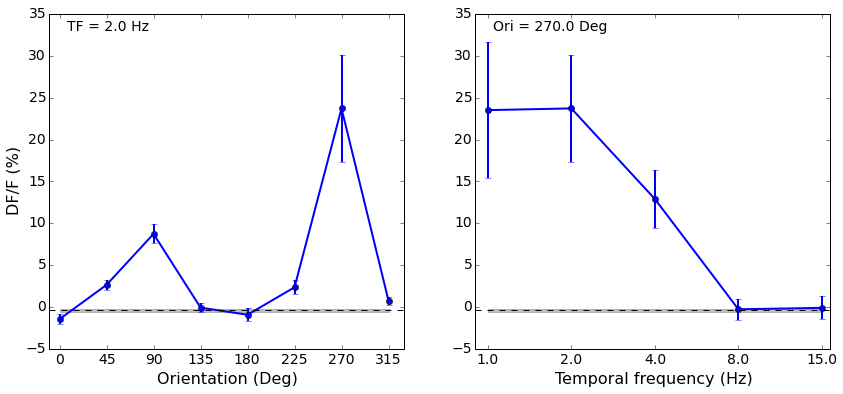

In [62]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.errorbar(orivals, ori_tuning, yerr=ori_sem, fmt='o-', color='blue', lw=2)
ax1.axhline(y=blank_mean, ls='--', color='k')
ax1.fill_between(orivals, np.repeat(blank_mean+blank_sem, len(orivals)), np.repeat(blank_mean-blank_sem, len(orivals)), color='gray', alpha=0.5)
ax1.set_ylabel("DF/F (%)", fontsize=16)
ax1.set_xlabel("Orientation (Deg)", fontsize=16)
ax1.set_xticks(range(0,360,45))
ax1.set_xlim(-10, 330)
ax1.tick_params(labelsize=14)
ax1.annotate("TF = " +str(peak_tf) + " Hz", xy=(0.05,0.95), xycoords='axes fraction', fontsize=14)

ax2 = plt.subplot(122, sharey=ax1)
ax2.errorbar(range(5), tf_tuning, yerr=tf_sem, fmt='o-', color='blue', lw=2)
ax2.axhline(y=blank_mean, ls='--', color='k')
ax2.fill_between(range(5), np.repeat(blank_mean+blank_sem, 5), np.repeat(blank_mean-blank_sem, 5), color='gray', alpha=0.5)
ax2.set_xlabel("Temporal frequency (Hz)", fontsize=16)
ax2.set_xlim(-0.15, 4.1)
ax2.set_xticks(range(5))
ax2.set_xticklabels(tfvals)
ax2.tick_params(labelsize=14)
ax2.annotate("Ori = " + str(peak_ori) + " Deg", xy=(0.05,0.95), xycoords='axes fraction', fontsize=14);

#Running speed
Load running speed and running timestamps

In [6]:
dxcm, dxtime = cn.getRunningSpeed(path)
print "Length of dxcm:" ,len(dxcm)
print "Length of celltraces: ", np.size(celltraces,1)

Length of dxcm: 57163
Length of celltraces:  57163


Running data is actually shorter than the fluorescence data, due to experimental details. We have padded it with NaNs for the timepoints at the beginning and/or end where we don't have running information. This allows us to directly compare running speed to fluorescence.

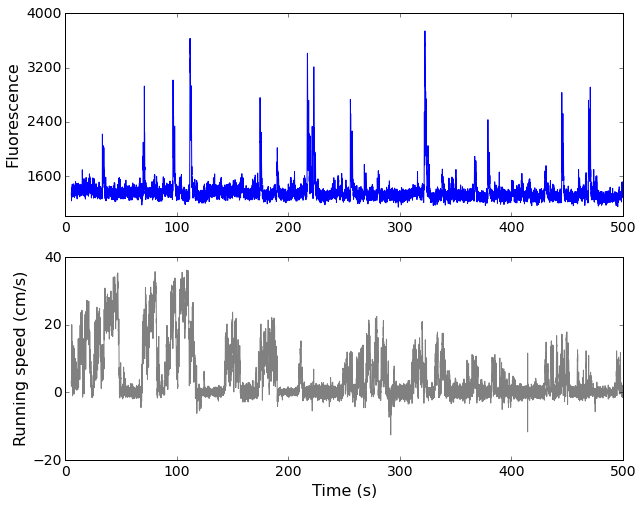

In [19]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax1.plot(timestamps, celltraces[roi_id,:])
ax1.set_ylabel("Fluorescence", fontsize=16)
ax1.tick_params(labelsize=14)
ax1.yaxis.set_major_locator(MaxNLocator(4))
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(dxtime, dxcm, color='gray')
ax2.set_ylabel("Running speed (cm/s)", fontsize=16)
ax2.set_xlabel("Time (s)", fontsize=16)
ax2.yaxis.set_major_locator(MaxNLocator(4))
ax2.tick_params(labelsize=14)
plt.xlim(0,500);

If we want to look at statistics of the running speed we need to account for the NaNs.

2.16523231477


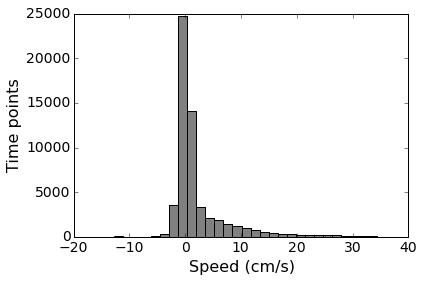

In [14]:
plt.hist(dxcm[~np.isnan(dxcm)], bins=30, color='gray');
plt.xlabel("Speed (cm/s)", fontsize=16)
plt.ylabel("Time points", fontsize=16)
plt.tick_params(labelsize=14)
print np.nanmean(dxcm)

It's hard to make any claims about the effect of running on cell activity simply by looking at the two plots. To better compare the ROI fluorescence to the mouse's running speed, we want to compute a speed tuning curve. To do this, ranksort the data based on the running speed, and take the mean & sem for bins of datapoints.

In [16]:
#specify the number of points you want to bin
binsize=400         
nbins = len(dxcm)/binsize

#rank sort both speed and fluorescence by the speed.
dx_sorted = dxcm[np.argsort(dxcm)]
celltraces_sorted = celltraces[:, np.argsort(dxcm)]

#only want to use the data when we have running speed info  
celltraces_sorted = celltraces_sorted[:,~np.isnan(dx_sorted)]
dx_sorted = dx_sorted[~np.isnan(dx_sorted)]

#bin the data, calculating the mean and sem
binned_cells = np.zeros((number_cells, nbins, 2))
binned_dx = np.zeros((nbins,2))
for i in range(nbins):
    start = i*binsize
    binned_dx[i,0] = np.mean(dx_sorted[start:start+binsize])
    binned_dx[i,1] = np.std(dx_sorted[start:start+binsize])/np.sqrt(binsize)
    binned_cells[:,i,0] = np.mean(celltraces_sorted[:, start:start+binsize], axis=1)
    binned_cells[:,i,1] = np.std(celltraces_sorted[:,start:start+binsize], axis=1)/np.sqrt(binsize)

Now we can plot the speed tuning for this cell.

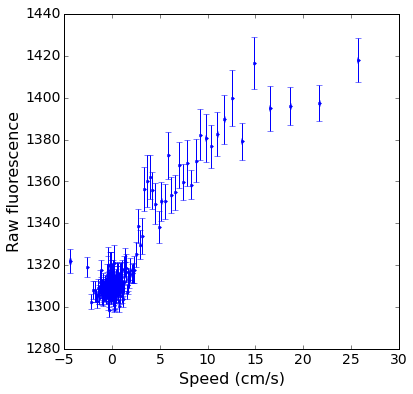

In [17]:
plt.figure(figsize=(6,6))
plt.errorbar(binned_dx[:,0], binned_cells[roi_id,:,0], yerr=binned_cells[roi_id,:,1], xerr=binned_dx[:,1], fmt='.')
plt.xlabel("Speed (cm/s)", fontsize=16)
plt.ylabel("Raw fluorescence", fontsize=16)
plt.tick_params(labelsize=14)

##Homework
    Make a DataFrame of metadata from all CAM experiments
    Add a metric of running speed (eg. mean speed) to that DataFrame
    Define DF/F in three different ways, compare differences
    Plot stimulus triggered trials
    Compute tuning curves (Ori and TF) using different DF/F methods
    Calculate speed tuning curves with DF/F instead of raw Fluorescence
    Compute ori and TF tuning of the running speed (eg. does the mouse run faster for different grating conditions?)
    Compare motion correction to running speed - do they correlate?
    Compute correlations between neurons (noise & stim)
    Make a mask of the ROIs colored by the response properties of the ROIs (eg. pref Ori or OSI or speed gain)
    

##Projects
    Motion correction - explore methods for aligning image frames using the raw movies
    Segmentation
    Neuropil subtraction
    Extract spike times; compute tuning curves using spike times and compare with DF/F
    Motif statistics from functional connectivity
    Fit models to neural responses (eg. GLM)
    Stimulus dependence of functional connectivity
    Layer/area specific response properties
    Trial variability
    Decode stimulus condition and/or running speed from single cell and population activity
    